In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Import libraries

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [ ]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [ ]:
def train_test_valid(data):
  test_size  = 0.2
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# HoaPhat_HPG

## Data

In [ ]:
df_amz = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/HoaPhat_HPG_y_m_d.csv")
df_amz

NameError: name 'pd' is not defined

## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_amz.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [ ]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-12-e30130b711a2>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_amz.iloc[0][0])
<ipython-input-12-e30130b711a2>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_amz.iloc[-1][0])
<ipython-input-12-e30130b711a2>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])


### Visualize the per day closing price of the stock

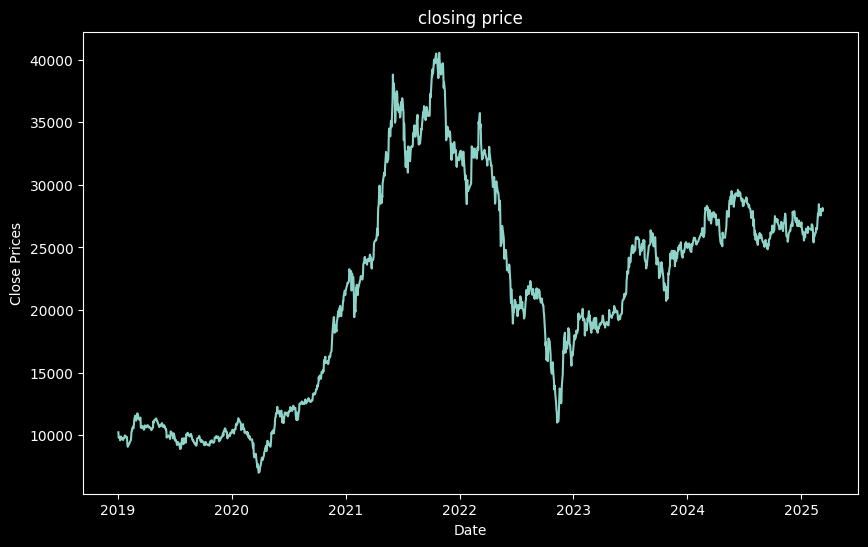

In [ ]:
x_axis = np.array(df_amz['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_amz)
plt.title('closing price')
plt.show()

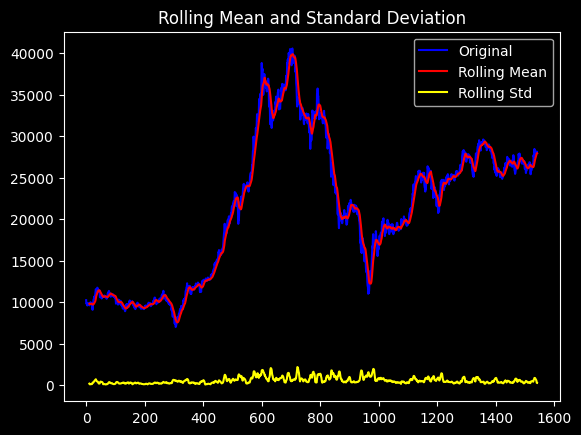

Results of dickey fuller test
Test Statistics                  -1.497438
p-value                           0.534778
No. of lags used                 15.000000
Number of observations used    1526.000000
critical value (1%)              -3.434642
critical value (5%)              -2.863436
critical value (10%)             -2.567779
dtype: float64


In [ ]:
test_stationarity(close_amz)

## Train, test, valid

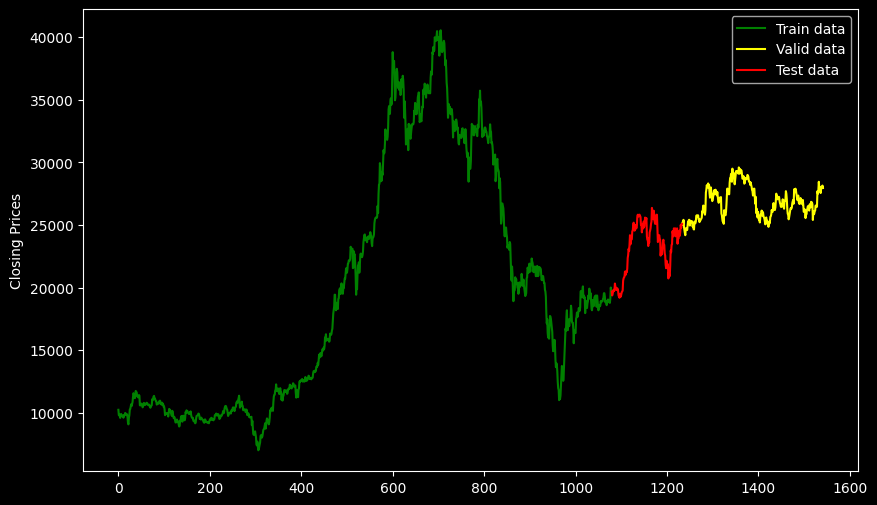

In [ ]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [ ]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

Vì Test Statistic (-1.497) lớn hơn tất cả các giá trị tới hạn, và p-value = 0.53 > 0.05, ta không bác bỏ giả thuyết H₀, tức là chuỗi KHÔNG dừng. Bạn bắt buộc phải sai phân chuỗi.

✅ Do đó, bạn cần d = 1 khi xây dựng mô hình ARIMA.
Trong R, auto.arima() có thể không chọn d = 1 đúng như mong đợi nếu bạn không chỉ định rõ — nó có thể cố gắng phù hợp dữ liệu gốc mà không sai phân, dẫn đến mô hình kém chính xác.

ép d = 1 trong auto.arima()

In [ ]:
model_autoARIMA = auto_arima(
    y_train,
    d=1,
    seasonal=False,
    stepwise=True,
    approximation=False,
    trace=True
)
model_autoARIMA.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16410.077, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16414.245, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16414.142, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16413.757, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16412.595, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16411.771, Time=1.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16411.155, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16412.040, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16411.387, Time=1.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16413.338, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16412.973, Time=0.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16412.720, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16412.926, Time=2.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=16408.382, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16410.137, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16409.532, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=16409.603, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=16409.616, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16411.624, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=16411.342, Time=1.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=16411.076, Time=1.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=16411.267, Time=2.57 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 20.767 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1079
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8199.191
Date:                Fri, 18 Apr 2025   AIC                          16408.382
Time:                        14:51:11   BIC                          16433.297
Sample:                             0   HQIC                         16417.817
                               - 1079                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1613      0.179     -0.903      0.367      -0.511       0.189
ar.L2         -0.5781      0.143     -4.035      0.000      -0.859      -0.297
ma.L1          0.2102      0.184      1.142      0.253      -0.150       0.571
ma.L2          0.5121      0.156      3.276      0.001       0.206       0.819
sigma2       2.38e+05   6498.999     36.617      0.000    2.25e+05    2.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               452.41
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.17   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [ ]:
model = ARIMA(y_train, order=(2,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1079
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8199.191
Date:                Fri, 18 Apr 2025   AIC                          16408.382
Time:                        14:51:27   BIC                          16433.297
Sample:                             0   HQIC                         16417.817
                               - 1079                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1613      0.179     -0.903      0.367      -0.511       0.189
ar.L2         -0.5781      0.143     -4.035      0.000      -0.859      -0.297
ma.L1          0.2102      0.184      1.142      0.253      -0.150       0.571
ma.L2          0.5121      0.156      3.276      0.001       0.206       0.819
sigma2       2.38e+05   6498.999     36.617      0.000    2.25e+05    2.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               452.41
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.17   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [ ]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  3608.9174751705714
MAPE:  14.831770479239603
RMSE:  4128.893813137271

** Validate **
MAE:  7126.56304224678
MAPE:  26.420545665206568
RMSE:  7237.988041909895


## Forecast

In [ ]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217 19682.54254217 19682.54254217
 19682.54254217 19682.54254217]


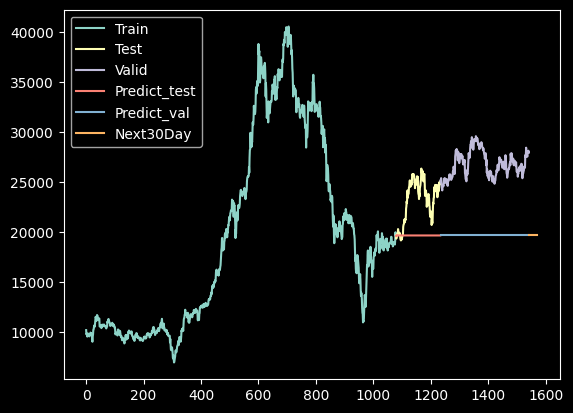

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NamKim_NKG

## Data

In [ ]:
df_tsla = pd.read_csv("/content/drive/MyDrive/IS403_Phantichdulieukinhdoanh/Đồ án/Data/cleandata/NamKim_NKG_y_m_d.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,4565.97,4577.55,4403.94,4403.94,4403.94,65576.0
1,2019-01-03,4403.94,4496.53,4195.60,4195.60,4195.60,559110.0
2,2019-01-04,4195.60,4195.60,3946.76,4079.86,4079.86,116707.0
3,2019-01-07,4079.86,4224.54,4079.86,4079.86,4079.86,132570.0
4,2019-01-08,4079.86,4155.09,4056.71,4079.86,4079.86,137979.0
...,...,...,...,...,...,...,...
1540,2025-03-06,15550.00,16100.00,15500.00,16100.00,16100.00,14202800.0
1541,2025-03-07,16050.00,16300.00,15900.00,16100.00,16100.00,10169700.0
1542,2025-03-10,16150.00,16200.00,15700.00,15800.00,15800.00,9795200.0
1543,2025-03-11,15500.00,16100.00,15400.00,16100.00,16100.00,14542500.0


## Preprocessing

### Check null and na value

In [ ]:
df_tsla.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_tsla.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [ ]:
close_tsla = df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2025-03-12 00:00:00
Duration:  2261 days 00:00:00


<ipython-input-44-72eea4c1fa3f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",df_tsla.iloc[0][0])
<ipython-input-44-72eea4c1fa3f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", df_tsla.iloc[-1][0])
<ipython-input-44-72eea4c1fa3f>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])


### Visualize the per day closing price of the stock

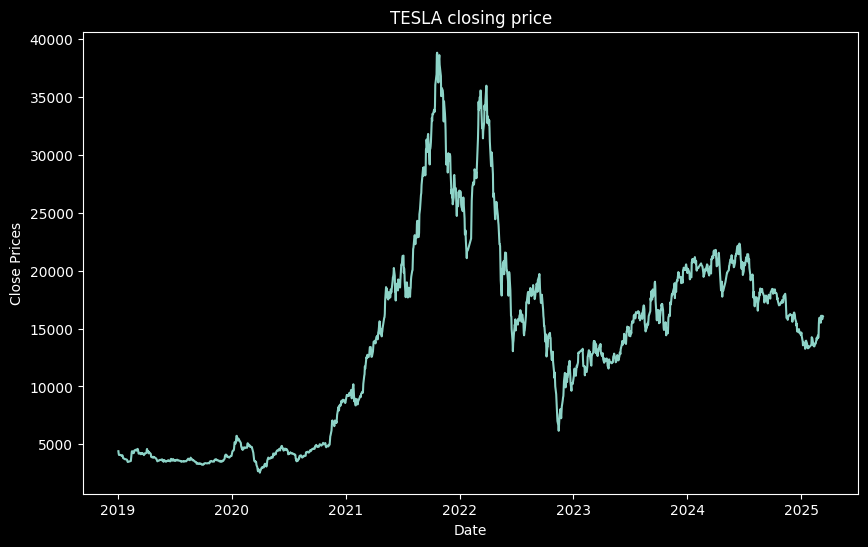

In [ ]:
x_axis = np.array(df_tsla['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_tsla)
plt.title('TESLA closing price')
plt.show()

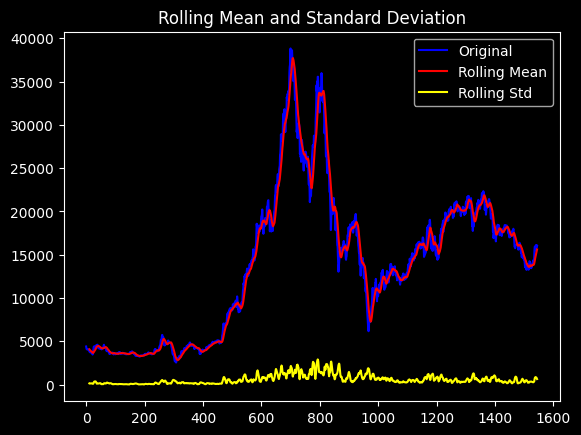

Results of dickey fuller test
Test Statistics                  -1.890192
p-value                           0.336689
No. of lags used                 24.000000
Number of observations used    1520.000000
critical value (1%)              -3.434659
critical value (5%)              -2.863443
critical value (10%)             -2.567783
dtype: float64


In [ ]:
test_stationarity(close_tsla)

## Train, test, valid

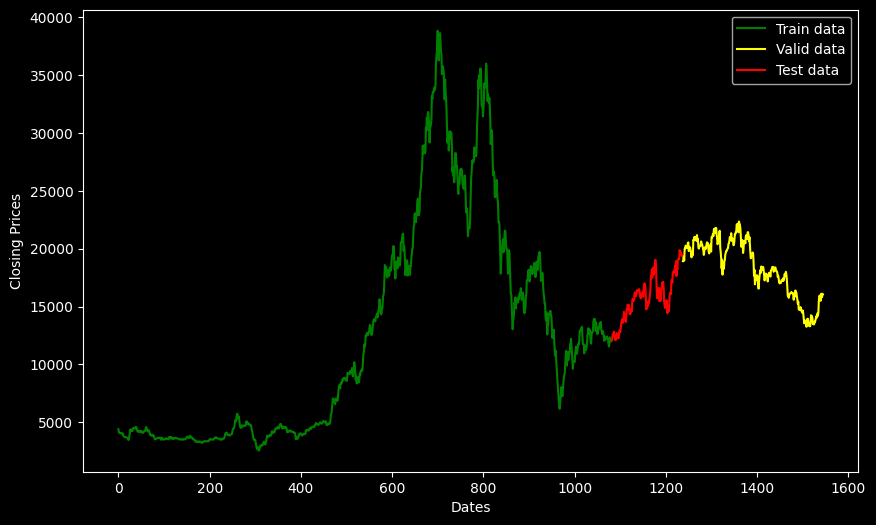

In [ ]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [ ]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [ ]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23932.463, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16528.521, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16528.200, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16529.364, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16528.334, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16527.725, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16527.378, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=1.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16529.240, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=16524.266, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=5.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=16520.360, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=16505.792, Time=1.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=16518.317, Time=1.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=16483.381, Time=2.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=16516.490, Time=1.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0]             : AIC=16513.418, Time=7.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(0,0,0)[0]             : AIC=16511.752, Time=2.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(0,0,0)[0]             : AIC=16507.877, Time=0.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0]             : AIC=16481.987, Time=2.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=16506.964, Time=2.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=16504.531, Time=3.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=16489.131, Time=5.55 sec

Best model:  ARIMA(5,0,3)(0,0,0)[0]          
Total fit time: 42.167 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1081
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -8231.993
Date:                Sun, 13 Apr 2025   AIC                          16481.987
Time:                        10:39:19   BIC                          16526.858
Sample:                             0   HQIC                         16498.976
                               - 1081                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1604      0.071     30.496      0.000       2.022       2.299
ar.L2         -2.3972      0.113    -21.173      0.000      -2.619      -2.175
ar.L3          2.2266      0.118     18.937      0.000       1.996       2.457
ar.L4         -1.0626      0.103    -10.280      0.000      -1.265      -0.860
ar.L5          0.0726      0.031      2.371      0.018       0.013       0.133
ma.L1         -1.0255      0.066    -15.629      0.000      -1.154      -0.897
ma.L2          1.1050      0.020     54.302      0.000       1.065       1.145
ma.L3         -0.8237      0.063    -13.059      0.000      -0.947      -0.700
sigma2      2.496e+05   4.83e-07   5.17e+11      0.000     2.5e+05     2.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               469.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              45.34   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+27. Standard errors may be unstable.
"""

### Build model

In [ ]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1081
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8260.251
Date:                Sun, 13 Apr 2025   AIC                          16528.501
Time:                        10:40:50   BIC                          16548.444
Sample:                             0   HQIC                         16536.052
                               - 1081                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.227e+04   8045.509      1.525      0.127   -3501.580     2.8e+04
ar.L1          0.9978      0.002    622.570      0.000       0.995       1.001
ma.L1          0.1357      0.020      6.900      0.000       0.097       0.174
sigma2      2.532e+05   6630.382     38.195      0.000     2.4e+05    2.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               560.46
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              44.50   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [ ]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  66.79800371664255
MAPE:  19.40351273437519
RMSE:  75.52558106757321

** Validate **
MAE:  46.03654163382529
MAPE:  25.94655322232406
RMSE:  54.473491719384214


## Forecast

In [ ]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[12163.30675484 12163.53271786 12163.75819003 12163.98317242
 12164.20766609 12164.43167209 12164.6551915  12164.87822537
 12165.10077474 12165.32284068 12165.54442424 12165.76552646
 12165.98614838 12166.20629106 12166.42595553 12166.64514283
 12166.86385399 12167.08209006 12167.29985207 12167.51714103
 12167.73395799 12167.95030397 12168.16617998 12168.38158706
 12168.59652621 12168.81099846 12169.02500483 12169.23854631
 12169.45162392 12169.66423868]


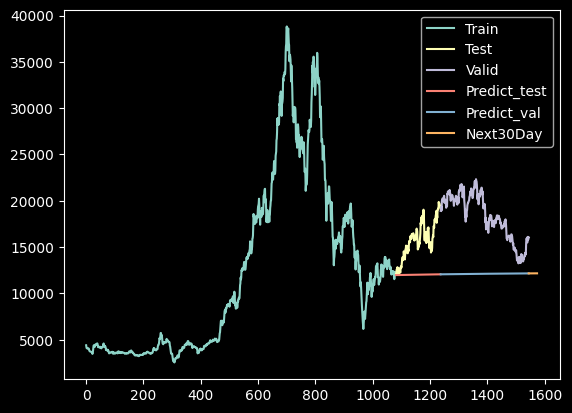

In [ ]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()